In [43]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
%cd  /content/drive/'My Drive/CV_proj'

/content/drive/My Drive/CV_proj


In [45]:
! pip install kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [46]:
!ls | grep CV_project

In [47]:
!kaggle datasets download -d jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [48]:
! kaggle datasets download jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [49]:
!unzip "celeba-dataset.zip" -d "/celeba/"

Streaming output truncated to the last 5000 lines.
  inflating: /celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197618.jpg

In [50]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 500 #999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  500


In [51]:
dataroot = "/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 256 #128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.000002 #0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

pretrained_generator_model_path = '/content/drive/MyDrive/CV_proj/DCGAN_generator.pth'
pretrained_discriminator_model_path = 'DCGAN_discriminator_model_10_2.pth'

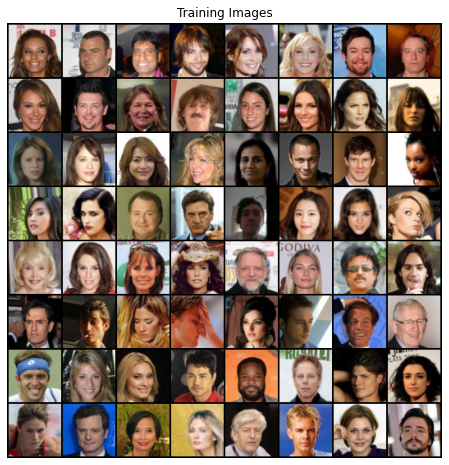

In [52]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [53]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device, torch.cuda.is_available())

cpu False


In [54]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [55]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [56]:
# netG = Generator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.02.
# netG.apply(weights_init)

# # Print the model
# print(netG)

netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(pretrained_generator_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [57]:
device

device(type='cpu')

In [58]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(20)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20, 20, kernel_size=3)
        self.batchnorm4 = nn.BatchNorm2d(20)
        # self.conv5 = nn.Conv2d(20, 20, kernel_size=3)
        # self.batchnorm5 = nn.BatchNorm2d(20)
        
        # self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(62720, 100)
        self.fc2 = nn.Linear(100, nclasses)

        for m in self.modules():
          if isinstance(m, nn.Conv2d):
              torch.nn.init.xavier_uniform(m.weight) #, nonlinearity='relu'
          elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)

    def forward(self, x):
        relu = nn.ReLU()

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = relu(x)
        x = self.conv3(x)
        # x = F.max_pool2d(x, 2)
        x = self.batchnorm3(x)
        x = relu(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = relu(x)

        # x = self.conv5(x)
        # x = F.max_pool2d(x, 2)
        # x = self.batchnorm5(x)
        x = relu(x)
        # x = drop_
        x = x.view(-1, 62720)
        # x = self.flatten(x)
        x = relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        sigmoid = nn.Sigmoid()
        x = sigmoid(x)
        return x 
        # return F.log_softmax(x,dim=1)


In [60]:
# netD = Net().to(device)
# netD = torch.load('D_model_10.pth').to(device)

netD = Discriminator(ngpu).to(device)
path = pretrained_discriminator_model_path
netD = torch.load(path).to(device)
# netD = torch.load('DCGAN_discriminator_model_10.pth').to(device)



for param in netD.parameters():
    param.requires_grad = False


In [61]:
# netD = Discriminator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# # Print the model
# print(netD)

In [62]:
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

temp = None
temp2 = None 
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        # netD.eval()

        # with torch.no_grad():
      
        netD.zero_grad() 
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.long, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch

        errD_real = criterion(output, label.float())
        # Calculate gradients for D in backward pass
        # errD_real.backward() ##uncomment
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch

        errD_fake = criterion(output, label.float())
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        # errD_fake.backward() ##uncomment

        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        # optimizerD.step() # uncomment

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        # netG.eval()
        # with torch.no_grad():
            
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label.float())
        # Calculate gradients for G
        errG.backward() ##uncomment
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step() ## uncomment


        # for param in netG.parameters():
        #   # print(param.detach().cpu())
        #   if(temp is not None):
        #     import numpy as np
        #     assert np.array_equal(temp, param.detach().cpu())
        #   temp = param.detach().cpu()
          
        #   break

        # for param in netD.parameters():
        #   # print(param.detach().cpu())

        #   if(temp2 is not None):
        #     import numpy as np
        #     assert np.array_equal(temp2, param.detach().cpu())
        #   temp2 = param.detach().cpu()
          
        #   break
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/2][0/792]	Loss_D: 0.0143	Loss_G: 6.8453	D(x): 0.9947	D(G(z)): 0.0080 / 0.0080
[0/2][50/792]	Loss_D: 0.3267	Loss_G: 2.4985	D(x): 0.9900	D(G(z)): 0.1988 / 0.1988
[0/2][100/792]	Loss_D: 1.7427	Loss_G: 0.5342	D(x): 0.9955	D(G(z)): 0.6827 / 0.6827
[0/2][150/792]	Loss_D: 2.9831	Loss_G: 0.2553	D(x): 0.9948	D(G(z)): 0.8353 / 0.8353
[0/2][200/792]	Loss_D: 3.8986	Loss_G: 0.1018	D(x): 0.9958	D(G(z)): 0.9264 / 0.9264
[0/2][250/792]	Loss_D: 4.2185	Loss_G: 0.0652	D(x): 0.9949	D(G(z)): 0.9449 / 0.9449
[0/2][300/792]	Loss_D: 4.6738	Loss_G: 0.0311	D(x): 0.9923	D(G(z)): 0.9713 / 0.9713
[0/2][350/792]	Loss_D: 5.3573	Loss_G: 0.0228	D(x): 0.9935	D(G(z)): 0.9789 / 0.9789
[0/2][400/792]	Loss_D: 5.5799	Loss_G: 0.0258	D(x): 0.9912	D(G(z)): 0.9770 / 0.9770
[0/2][450/792]	Loss_D: 5.7422	Loss_G: 0.0233	D(x): 0.9964	D(G(z)): 0.9794 / 0.9794
[0/2][500/792]	Loss_D: 5.9704	Loss_G: 0.0124	D(x): 0.9945	D(G(z)): 0.9883 / 0.9883
[0/2][550/792]	Loss_D: 6.1281	Loss_G: 0.0127	D(x): 0.9941	D(G(z)

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
torch.save(netD.state_dict(), 'DCGAN_mode_parameter1_freezing_D.pth')

In [ ]:
torch.save(netG.state_dict(), 'DCGAN_generator1_freezing_D.pth')

In [ ]:
fixed_noise = torch.randn(b_size, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img = vutils.make_grid(fake, padding=2, normalize=True)

In [ ]:
plt.imshow(np.transpose(img,(1,2,0)))

In [ ]:
# fixed_noise = torch.randn(b_size, nz, 1, 1, device=device)
netG2 = Generator(ngpu).to(device)
netG2.load_state_dict(torch.load(pretrained_generator_model_path, map_location=torch.device('cpu')))

with torch.no_grad():
    fake2 = netG2(fixed_noise).detach().cpu()
img2 = vutils.make_grid(fake2, padding=2, normalize=True)
plt.imshow(np.transpose(img2,(1,2,0)))

In [ ]:
plt.imshow(np.transpose(img-img2,(1,2,0)))

In [ ]:
plt.imshow(np.transpose(img+img2,(1,2,0)))

In [ ]:
x = img - img2
print(len(torch.where(x!=0)))
# torch.sum(img - img2)
print(x.shape)
print(len(torch.where(x==0)[0]), len(x[0]))
print(torch.mean(x))

In [ ]:

model = torch.load(pretrained_discriminator_model_path).to(device)


In [ ]:
# model_G = Generator(ngpu)#.to(device)
# model_G.load_state_dict(torch.load('/content/drive/MyDrive/CV_proj/DCGAN_generator.pth', map_location=torch.device('cpu'))) #.to(device)

X = []
y = []

# Getting Images from Traditional GAN model 


for i in range(50):
  # count1 += 64 
  fixed_noise = torch.randn(64, nz, 1, 1, device=device)
  with torch.no_grad():
    fake = netG2(fixed_noise).detach().cpu()
  # print(fake.shape)
  # print("BEFORE", torch.max(fake), torch.min(fake))
  
  # fake = (fake -0.5)/0.5
  # print("AFTER", torch.max(fake), torch.min(fake))
  X.append(fake)
  y.append(torch.zeros(len(fake)))

X =torch.cat(X, 0)
y = torch.cat(y,0)
print(X.shape, y.shape)

In [ ]:
# model_G = Generator(ngpu)#.to(device)
# model_G.load_state_dict(torch.load('/content/drive/MyDrive/CV_proj/DCGAN_generator.pth', map_location=torch.device('cpu'))) #.to(device)

X_new = []
y_new = []

# Getting Images from "New" trained GAN model 


for i in range(50):
  # count1 += 64 
  fixed_noise = torch.randn(64, nz, 1, 1, device=device)
  with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
  # print(fake.shape)
  # print("BEFORE", torch.max(fake), torch.min(fake))
  
  # fake = (fake -0.5)/0.5
  # print("AFTER", torch.max(fake), torch.min(fake))
  X_new.append(fake)
  y_new.append(torch.zeros(len(fake)))

X_new =torch.cat(X_new, 0)
y_new = torch.cat(y_new,0)
print(X_new.shape, y_new.shape)

In [ ]:
count2 = 0
import numpy as np 
from PIL import Image
import glob
X_real = []
y_real = []

transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
for i in glob.glob(dataroot + '/img_align_celeba/img_align_celeba/*'):
  count2+=1 
  if (count2<=3200):
    im = Image.open(i)
    im = transform(im)
    im = im.unsqueeze(0)
    if(count2==1):
      X_real = im
      y_real = torch.tensor(1).unsqueeze(0)
    else:
      X_real = torch.cat((X_real,im ), 0)
      y_real = torch.cat((y_real, torch.tensor(1).unsqueeze(0)), 0)
  if(count2>=3200):
    break 



In [ ]:
X_trad = torch.cat((X, X_real), 0)
y_trad = torch.cat((y, y_real), 0)





In [ ]:
print(X_trad.shape, y_trad.shape)

In [ ]:
X_new = torch.cat((X_new, X_real), 0)
y_new = torch.cat((y_new, y_real), 0)

In [ ]:

from torch.utils.data import TensorDataset, DataLoader

my_dataset_trad = TensorDataset(X_trad, y_trad) # create your datset
trad_loader = DataLoader(my_dataset_trad, batch_size=32, shuffle=True)




In [ ]:

print(X_new.shape, y_new.shape)

my_dataset_new = TensorDataset(X_new, y_new) # create your datset
new_loader = DataLoader(my_dataset_new, batch_size=32, shuffle=True)


In [ ]:
def validation(test_loader, model):
    model.eval()
    model = model.to(device)
    validation_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.to(device).float()
        target = target.to(device).long()
        output = model(data).view(-1)

        # validation_loss = loss_func(output, target.float())
        # validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        # pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = torch.zeros(output.data.shape).to(device)
        pred[output.data >=0.5] = 1
        # print(pred.shape, target.shape)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss = 0 # /= len(test_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
# new_loader = new_loader.to(device)
validation(new_loader, model)

In [ ]:
validation(trad_loader, model)